## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# Enable GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1]
redice_lr_patient = [2, 6]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s:%s:%s" % (str(optim).split('.')[-1].split(' ')[0],str(reduce_factor),str(reduce_patient)))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 2
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_

Epoch 5/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5571 - accuracy: 0.4526 - val_loss: 1.6850 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 2s 33ms/step - loss: 1.5149 - accuracy: 0.4683 - val_loss: 1.6283 - val_accuracy: 0.4228 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 1s 30ms/step - loss: 1.4790 - accuracy: 0.4826 - val_loss: 1.5767 - val_accuracy: 0.4478 - lr: 0.0010
Epoch 8/25
49/49 [==============================] - 1s 30ms/step - loss: 1.4462 - accuracy: 0.4935 - val_loss: 1.5467 - val_accuracy: 0.4546 - lr: 0.0010
Epoch 9/25
49/49 [==============================] - 1s 30ms/step - loss: 1.4184 - accuracy: 0.5042 - val_loss: 1.5253 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 10/25
49/49 [==============================] - 2s 31ms/step - loss: 1.3908 - accuracy: 0.5140 - val_loss: 1.5160 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 11/25
49/49 [==============================] - 1s 30ms/step - loss: 1

Epoch 21/25
49/49 [==============================] - 1s 30ms/step - loss: 1.1571 - accuracy: 0.6054 - val_loss: 1.4399 - val_accuracy: 0.4887 - lr: 0.0010
Epoch 22/25
49/49 [==============================] - 1s 30ms/step - loss: 1.1399 - accuracy: 0.6104 - val_loss: 1.4305 - val_accuracy: 0.4847 - lr: 0.0010
Epoch 23/25
49/49 [==============================] - 2s 32ms/step - loss: 1.1219 - accuracy: 0.6167 - val_loss: 1.4220 - val_accuracy: 0.4955 - lr: 0.0010
Epoch 24/25
49/49 [==============================] - 1s 30ms/step - loss: 1.1048 - accuracy: 0.6232 - val_loss: 1.4243 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 25/25
47/49 [===========================>..] - ETA: 0s - loss: 1.0883 - accuracy: 0.6296
Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
49/49 [==============================] - 1s 30ms/step - loss: 1.0873 - accuracy: 0.6301 - val_loss: 1.4271 - val_accuracy: 0.4875 - lr: 0.0010
Numbers of exp: 3, reduce_factor: 0.10, reduce_patient: 6
Mod

Epoch 1/25
49/49 [==============================] - 2s 32ms/step - loss: 1.6930 - accuracy: 0.4012 - val_loss: 2.4564 - val_accuracy: 0.1534 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 1s 30ms/step - loss: 1.4113 - accuracy: 0.5008 - val_loss: 1.7703 - val_accuracy: 0.3699 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 1s 30ms/step - loss: 1.2820 - accuracy: 0.5475 - val_loss: 1.6432 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 1s 30ms/step - loss: 1.1849 - accuracy: 0.5844 - val_loss: 1.9467 - val_accuracy: 0.3446 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 2s 31ms/step - loss: 1.0988 - accuracy: 0.6139 - val_loss: 1.5780 - val_accuracy: 0.4418 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 1s 30ms/step - loss: 1.0214 - accuracy: 0.6425 - val_loss: 1.8919 - val_accuracy: 0.3617 - lr: 0.0010
Epoch 7/25
47/49 [===========================>..] - ETA: 0s - loss: 0.9506 -

Epoch 8/25
49/49 [==============================] - 1s 30ms/step - loss: 1.7573 - accuracy: 0.3869 - val_loss: 1.7954 - val_accuracy: 0.3759 - lr: 3.9063e-06
Epoch 9/25
49/49 [==============================] - 1s 30ms/step - loss: 1.7374 - accuracy: 0.3933 - val_loss: 1.7761 - val_accuracy: 0.3837 - lr: 3.9063e-06
Epoch 10/25
49/49 [==============================] - 1s 30ms/step - loss: 1.7192 - accuracy: 0.4007 - val_loss: 1.7591 - val_accuracy: 0.3884 - lr: 3.9063e-06
Epoch 11/25
49/49 [==============================] - 1s 30ms/step - loss: 1.7035 - accuracy: 0.4066 - val_loss: 1.7461 - val_accuracy: 0.3960 - lr: 3.9063e-06
Epoch 12/25
49/49 [==============================] - 2s 32ms/step - loss: 1.6889 - accuracy: 0.4121 - val_loss: 1.7322 - val_accuracy: 0.3991 - lr: 3.9063e-06
Epoch 13/25
49/49 [==============================] - 1s 30ms/step - loss: 1.6753 - accuracy: 0.4155 - val_loss: 1.7215 - val_accuracy: 0.4030 - lr: 3.9063e-06
Epoch 14/25
49/49 [=============================

Epoch 23/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5581 - accuracy: 0.4629 - val_loss: 1.6324 - val_accuracy: 0.4325 - lr: 3.9063e-06
Epoch 24/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5511 - accuracy: 0.4660 - val_loss: 1.6268 - val_accuracy: 0.4335 - lr: 3.9063e-06
Epoch 25/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5442 - accuracy: 0.4682 - val_loss: 1.6211 - val_accuracy: 0.4363 - lr: 3.9063e-06
Numbers of exp: 7, reduce_factor: 0.10, reduce_patient: 6
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)            

49/49 [==============================] - 2s 35ms/step - loss: 1.7207 - accuracy: 0.3921 - val_loss: 2.2697 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 2s 32ms/step - loss: 1.4484 - accuracy: 0.4843 - val_loss: 2.2737 - val_accuracy: 0.2196 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 2s 32ms/step - loss: 1.3349 - accuracy: 0.5255 - val_loss: 1.9403 - val_accuracy: 0.3227 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 2s 33ms/step - loss: 1.2400 - accuracy: 0.5603 - val_loss: 1.6859 - val_accuracy: 0.3957 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 2s 33ms/step - loss: 1.1718 - accuracy: 0.5856 - val_loss: 1.9490 - val_accuracy: 0.3669 - lr: 0.0010
Epoch 6/25
47/49 [===========================>..] - ETA: 0s - loss: 1.1026 - accuracy: 0.6132
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
49/49 [==============================] - 2s 32ms/step - loss: 1.104

Epoch 7/25
49/49 [==============================] - 2s 32ms/step - loss: 2.1993 - accuracy: 0.2323 - val_loss: 2.1748 - val_accuracy: 0.2323 - lr: 1.9531e-06
Epoch 8/25
49/49 [==============================] - 2s 33ms/step - loss: 2.1629 - accuracy: 0.2447 - val_loss: 2.1519 - val_accuracy: 0.2432 - lr: 1.9531e-06
Epoch 9/25
49/49 [==============================] - 2s 32ms/step - loss: 2.1301 - accuracy: 0.2560 - val_loss: 2.1285 - val_accuracy: 0.2547 - lr: 1.9531e-06
Epoch 10/25
49/49 [==============================] - 2s 34ms/step - loss: 2.0997 - accuracy: 0.2661 - val_loss: 2.1049 - val_accuracy: 0.2646 - lr: 1.9531e-06
Epoch 11/25
49/49 [==============================] - 2s 33ms/step - loss: 2.0718 - accuracy: 0.2741 - val_loss: 2.0809 - val_accuracy: 0.2736 - lr: 1.9531e-06
Epoch 12/25
49/49 [==============================] - 2s 32ms/step - loss: 2.0468 - accuracy: 0.2824 - val_loss: 2.0584 - val_accuracy: 0.2814 - lr: 1.9531e-06
Epoch 13/25
49/49 [==============================

Epoch 22/25
49/49 [==============================] - 2s 35ms/step - loss: 1.8622 - accuracy: 0.3408 - val_loss: 1.8799 - val_accuracy: 0.3391 - lr: 1.9531e-06
Epoch 23/25
49/49 [==============================] - 2s 32ms/step - loss: 1.8503 - accuracy: 0.3455 - val_loss: 1.8695 - val_accuracy: 0.3402 - lr: 1.9531e-06
Epoch 24/25
49/49 [==============================] - 2s 32ms/step - loss: 1.8384 - accuracy: 0.3496 - val_loss: 1.8589 - val_accuracy: 0.3444 - lr: 1.9531e-06
Epoch 25/25
49/49 [==============================] - 2s 33ms/step - loss: 1.8282 - accuracy: 0.3529 - val_loss: 1.8496 - val_accuracy: 0.3461 - lr: 1.9531e-06
Numbers of exp: 11, reduce_factor: 0.10, reduce_patient: 6
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)  

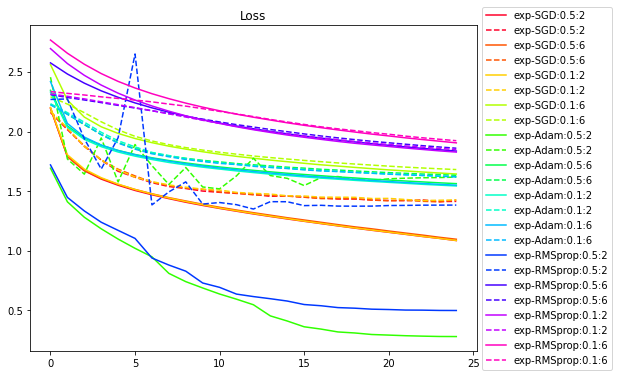

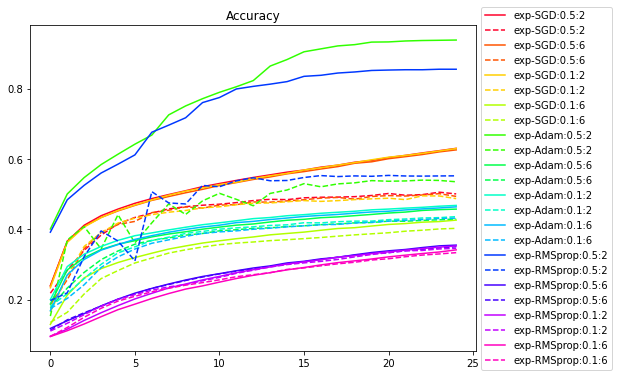

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()